Name: Tchangmena A Nken Allassan

The github account is [here](https://github.com/matzolla/)

creation date: 01/11/2021

update date: 04/11/2021

We still use a GPU here, this is the final notebook

After implementing an RCNN, we perform bounding box regression. The idea came from this [link](https://www.pyimagesearch.com/2020/10/12/multi-class-object-detection-and-bounding-box-regression-with-keras-tensorflow-and-deep-learning/)

In [1]:
#!unzip "drive/MyDrive/train_folder.zip"

In [2]:
#import necessary librairies
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

In [19]:
import pandas as pd
import imutils

In [4]:
#sample head
path_csv="Koubrah/csv_files/healthy.csv"
train=pd.read_csv(path_csv)

In [5]:
train.tail()

,id,ymin,xmin,ymax,xmax,class
6478,fruit_healthy_6479.jpg,232,407,338,512,healthy
6479,fruit_healthy_6480.jpg,233,405,332,512,healthy
6480,fruit_healthy_6481.jpg,181,407,338,512,healthy
6481,fruit_healthy_6482.jpg,232,405,335,512,healthy
6482,fruit_healthy_6483.jpg,223,53,404,225,healthy


## Preparing the data

In [6]:
##creating list files for data
data=[]
classes=[]
b_box=[] #bounding boxes
path_to_images=[]

In [7]:
for csv in paths.list_files('Koubrah/csv_files',validExts='csv'):

  ##loop over the csv_files
  rows=open(csv).read().strip().split("\n")

  for row in rows[:1500]:
    
    row=row.split(',')
    
    if 'id' not in row:
      
      (image_id,ymin,xmin,ymax,xmax,label)=row

      ## open path to images and reshaping them ####
      img_path=os.path.sep.join(["Koubrah","images_folder","fruit_"+label,image_id])

      if os.path.exists(img_path):
        
        image=cv2.imread(img_path)

        ## rescaling bounding boxes
        ymin=float(ymin)/224

        xmin=float(xmin)/224

        ymax=float(ymax)/224

        xmax=float(xmax)/224

        ## load images
        image=load_img(img_path,target_size=(224,224))

        ## image to array
        image=img_to_array(image)

        ## appending values
        data.append(image)
        classes.append(label)
        b_box.append((ymin,xmin,ymax,xmax))
        path_to_images.append(img_path)

In [8]:
data=np.array(data,dtype="float32")/255.0
classes=np.array(classes)
b_box=np.array(b_box,dtype="float32")
path_to_images=np.array(path_to_images)

In [9]:
#performing one hot encoding
lb=LabelBinarizer()
classes=lb.fit_transform(classes)

In [10]:
#if we have two classes we can just do categorical encoding
if len(lb.classes_)==2:
  classes=to_categorical(classes)

In [11]:
#splitting the data into the train and test set
split=train_test_split(data,classes,b_box,path_to_images,test_size=0.2,random_state=42)

In [12]:
#now we unpack the data split
(train_img,test_img)=split[:2]
(train_label,test_label)=split[2:4]
(train_bbox,test_bbox)=split[4:6]
(train_path,test_path)=split[6:]

In [13]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [14]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [15]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=0.001)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": train_label,
	"bounding_box": train_bbox
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": test_label,
	"bounding_box": test_bbox
}

In [17]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	train_img, trainTargets,
	validation_data=(test_img, testTargets),
	batch_size=64,
	epochs=10,
	verbose=1)

[INFO] training model...
Epoch 1/10
57/57 [==============================] - 87s 724ms/step - loss: 1.9592 - bounding_box_loss: 0.4996 - class_label_loss: 1.4596 - bounding_box_accuracy: 0.4251 - class_label_accuracy: 0.5791 - val_loss: 1.0024 - val_bounding_box_loss: 0.4597 - val_class_label_loss: 0.5427 - val_bounding_box_accuracy: 0.4856 - val_class_label_accuracy: 0.7689
Epoch 2/10
57/57 [==============================] - 33s 587ms/step - loss: 0.9026 - bounding_box_loss: 0.3965 - class_label_loss: 0.5061 - bounding_box_accuracy: 0.4874 - class_label_accuracy: 0.8043 - val_loss: 0.7015 - val_bounding_box_loss: 0.3907 - val_class_label_loss: 0.3108 - val_bounding_box_accuracy: 0.3633 - val_class_label_accuracy: 0.8889
Epoch 3/10
57/57 [==============================] - 33s 585ms/step - loss: 0.7809 - bounding_box_loss: 0.3877 - class_label_loss: 0.3932 - bounding_box_accuracy: 0.3367 - class_label_accuracy: 0.8438 - val_loss: 0.7061 - val_bounding_box_loss: 0.3876 - val_class_label_

In [25]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save("drive/MyDrive/detector.h5", save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open("drive/MyDrive/lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving object detector model...
[INFO] saving label binarizer...


In [4]:
# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = load_model("drive/MyDrive/detector.h5")
lb = pickle.loads(open("drive/MyDrive/lb.pickle", "rb").read())

[INFO] loading object detector...


In [5]:
pip install -q git+https://github.com/eaedk/testing-zindi-package.git

In [6]:
# Import Zindian class from the package
from zindi.user import Zindian

In [7]:
# create a user object
my_username = "Tony_Stark"
user = Zindian(username = my_username)

Your password
>> ··········

[ 🟢 ] 👋🏾👋🏾 Welcome Tony_Stark 👋🏾👋🏾



In [8]:
user.select_a_challenge()                               # Select a Zindi challenge
user.which_challenge                                    # Get information about the selected challenge

__________________________________________________________________________________________________________________________________
|     |              |                  |                    |          
|index|  challenge   |     problem      |       reward       |    id    
|     |              |                  |                    |          
----------------------------------------------------------------------------------------------------------------------------------
|  0  | Public Hack  |  Classification  |      $300 USD      | kenyan-sign-language-classification-hackathon...
----------------------------------------------------------------------------------------------------------------------------------
|  1  |Public Compet |  Classification  |     $7 500 USD     | bloodsai-blood-spectroscopy-classification-challen...
----------------------------------------------------------------------------------------------------------------------------------
|  2  |Public Compet |Automa

'makerere-passion-fruit-disease-detection-challenge'

In [9]:
user.download_dataset(destination="dataset") # Download the dataset of the selected challenge

dataset/PassionfruitStarterNotebook.ipynb: 100%|██████████| 609k/609k [00:01<00:00, 555ko/s]
dataset/Test.csv: 100%|██████████| 10.9k/10.9k [00:00<00:00, 5.41Mo/s]
dataset/Sample_submission.csv: 100%|██████████| 16.4k/16.4k [00:00<00:00, 7.18Mo/s]
dataset/Train_Images.zip: 100%|██████████| 293M/293M [00:50<00:00, 6.04Mo/s]
dataset/Test_Images.zip: 100%|██████████| 36.4M/36.4M [00:09<00:00, 3.86Mo/s]
dataset/Train.csv: 100%|██████████| 192k/192k [00:00<00:00, 294ko/s] 


In [11]:
#!unzip 'dataset/Test_Images.zip'

In [12]:
test_path="Test_Images/"

In [85]:
l=os.listdir(test_path)

In [148]:
# load the input image (in Keras format) from disk and preprocess
# it, scaling the pixel intensities to the range [0, 1]
image = load_img(test_path+l[470], target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# predict the bounding box of the object along with the class
# label
(boxPreds, labelPreds) = model.predict(image)
(ymin, xmin, ymax, xmax) = boxPreds[0]
# determine the class label with the largest predicted
# probability
i = np.argmax(labelPreds, axis=1)
label = lb.classes_[i][0]

In [133]:
from google.colab.patches import cv2_imshow

In [149]:
image = cv2.imread(test_path+l[470])
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
xmin = int(xmin*w)
ymin = int(ymin*h)
xmax = int(xmax*w)
ymax = int(ymax*h)
# draw the predicted bounding box and class label on the image
y = xmin - 10 if ymin - 10 > 10 else xmin + 10
#y = xmin - 10 if ymin - 10 > 10 else xmin + 10
cv2.putText(image, label, (xmin, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(image, (xmin, y), (xmax, ymax),(0, 255, 0), 2)
	# show the output image

array([[[233, 226, 217],
        [220, 211, 202],
        [210, 199, 192],
        ...,
        [107, 114, 133],
        [108, 115, 134],
        [106, 113, 132]],

       [[239, 232, 223],
        [223, 214, 205],
        [211, 200, 193],
        ...,
        [105, 112, 131],
        [105, 112, 131],
        [104, 111, 130]],

       [[247, 239, 231],
        [226, 217, 208],
        [212, 201, 194],
        ...,
        [100, 109, 128],
        [101, 110, 128],
        [101, 110, 128]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 71,  93, 129],
        [ 68,  90, 126],
        [  0, 255,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

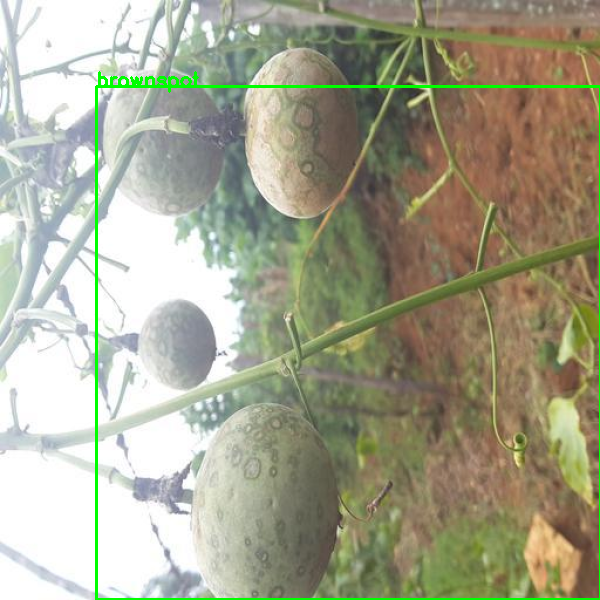

-1

In [150]:
cv2_imshow(image)
cv2.waitKey(0)

In [137]:
train=pd.read_csv('dataset/Train.csv')

In [138]:
train.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0
